# CTFT->DTFT->DFT->FFT

 - [1] https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html
 - [2] http://eceweb1.rutgers.edu/~gajic/solmanual/slides/chapter9_DFT.pdf
 - [3] http://www.johnkerl.org/doc/fourpoi-slides.pdf
 - [4] https://web.iit.edu/sites/web/files/departments/academic-affairs/academic-resource-center/pdfs/nyquistSamplingTheorem1.pdf
 - [5] https://engineering.purdue.edu/~bouman/ece637/notes/pdf/CTFT.pdf

### Dirac Delta function

The Fourier series of Delta function can be derived as:
$$
\delta(t) = \frac{1}{2\pi} \sum_{k=-\infty}^{\infty} e^{jkt} = 1 + 2 \sum_{k=1}^{\infty} cos 2\pi kx
$$

Although it's not a converge sequence, which is expected since delta function itself is un-limited in magnitude, but we can see that in the limit sense (from the code below) that the equation is truly correct.

Since Fourier series represent periodic function, so it's actually impulse train rather than a single delta function:
$$
\sum_k \delta(t-k) = \sum_k e^{j2\pi kt}
$$

More generally:
$$
\sum_k \delta(t-kT) = \frac{1}{T} \sum_k \delta(t/T-k) = \frac{1}{T} \sum_k e^{j2\pi kt/T}
$$
and its CTFT is also a impulse train:
$$
\begin{align*}
\sum_k \delta(t-kT) \xtofrom{CTFT} \int \sum_k \delta(t-kT) e^{-j\omega t} dt = \sum_k e^{-j\omega kT} &= \frac{2\pi}{T} \sum_k \delta(\omega-k\frac{2\pi}{T}) \\
&= \frac{1}{T} \sum_k \delta(f-k\frac{1}{T})

\end{align*}
$$

- https://www.sciencedirect.com/topics/mathematics/poisson-summation-formula
- https://www.sciencedirect.com/topics/mathematics/delta-function

Text(0.5, 0, 'pi')

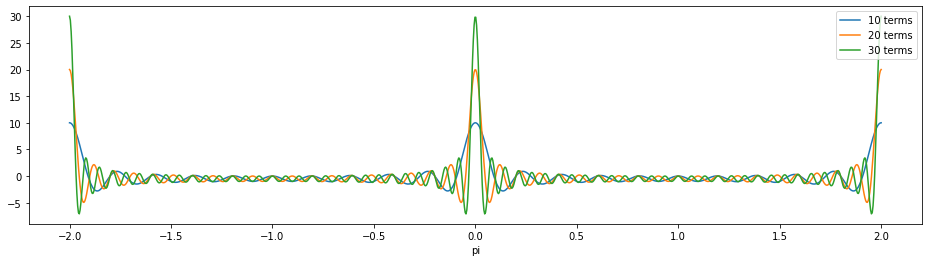

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
t=np.linspace(-2, 2, 1000); x = t*0
for m in range(1, 1000+1):
    x += np.cos(m*t*np.pi)
    if m in (10,20,30): plt.plot(t, x.copy(), label="{} terms".format(m))
plt.legend(); plt.xlabel("pi")


Possion summation formula can be derived from that:

$$
\begin{align*}
\sum_k x(k) &= \sum_k \int x(t) \delta(t-k) dt = \int x(t) \sum_k \delta(t-k) dt \\
            &= \int x(t) \sum_k e^{j2\pi kt} dt = \sum_k \int x(t) e^{-j2\pi kt} dt \\
            &= \sum_k X(jk)
\end{align*}
$$

### Sampling process
The sampling process (w/o the need of DTFT) in CT domain can be modeled with impulse train multiplication.(although not accurate since the result signal would have infinite magnitude at discrete time steps, but that's neccessary to get a meaningful spectrum)

$$
   x_s(t) = x(t) \sum_n \delta (t-nT_s) \xtofrom{CTFT} \frac{1}{T_s} \sum_n X(f - nf_s)
$$

so we can see easily how the alias would happen.
 - https://image.slideserve.com/464902/sampling-theorem-multiplication-in-image-domain-is-convolution-in-spectral-l.jpg

### DTFT
In general `CTFT` $X(j\omega)$ can be approximated using [Riemann sum](https://brilliant.org/wiki/riemann-sums/), but for sampled signal which's CTFT is periodic function, and the computation can be done exactly using sum instead of integral. 

$$
\begin{align*}
X(j\omega) &= \int_{-\infty}^{\infty} x(t) \sum_k \delta (t-kT_s) e^{-j\omega t} dt \\
           &= \sum_{k=-\infty}^{\infty} x(kT_s)e^{-j\omega kT_s} \\
           &\xlongequal{x_k=x(kT_s) \ \ \Omega = \omega T_s } \sum_{k=-\infty}^{\infty} x_k e^{-jk\Omega} \\
           &= X(\Omega)
\end{align*}
$$

So `DTFT` is exactly CTFT for sampled signal, due to the discrete sampling, it becomes periodical with period $2\pi$, and $\omega$ with period $2\pi/T_s = 2\pi f_s$.

### DFT
DTFT is defined for non-periodic signal of infinite length, periodic signal can be viewed as a signal of finite duration(have zero magnitude outside the durarion) convoluted by unit impulse train signal:

$$
x_0(t) \ast \sum_k \delta (t-kT_0) \xtofrom{CTFT}  X_0(j\omega) \omega_0 \sum_k \delta (\omega-k\omega_0)
$$
the result is discrete sampling of CTFT, and is CFS(continouse Fourier series). Here:
 - x0(t) is one-cycle sample of the periodic signal which is symmetric around origin and has non-zero value only in (-T/2, T/2] range.
 - the sampling interval in frequency domain is exactly the fundamental frequency of the periodic signal x.
 - the CTFT is not converge because of the delta function, so we only care about the propotional result.
 
if x(t) is also a discrete sampled signal at the same time, then we just need to calculate DTFT at discrete frequency point $n\omega_0 T_s = 2\pi n/(T_0/T_s) = 2\pi n/N$.

$$
DFT\{x[k]\} = X(\Omega_n) = \sum_{k=0}^{L-1} x[k] e^{-j2\pi \frac{kn}{N}}
$$

`FFT` is just DFT with N == L.

## Simple notation
let $e_{kn}$ denotes $e^{-j2\pi\frac{kn}{N}}$ which is function of k*n with period N, $ e_{-kn} = e_{k(N-n)} = e_{(N-k)n} $ we have:
 
$$
 X[n] = \sum_{k=0}^{N-1} x_k e_{kn} \\
 x_k = \frac{1}{N} \sum_{n=0}^{N-1} y_n e_{-kn}
$$

Since from above definition both $x_k$ and X[n] are sum of $e_{-kn}$, so we know they are all periodic signal with period N:

$$
X[n] = X[n+N] = X[n+2N] ... \\
x_k = x_{k+N} = x_{k+2N} ...
$$

When we do FFT on a signal, we are actually take a windowed segment of it and repeat that segment periodically.

## FFT of Time reversed signal is conjugate of FFT of orginal signal

$$
 X^*[n] \xtofrom{FFT} x_{-n}
$$

prove:

$$
\begin{align*}
X[n] &= \sum_k x_k e_{kn} \\
X^*[n] &= \sum_k x_k e_{-kn} = \sum_k x_k e_{(N-k)n} \\
       &\xlongequal{k'=N-k} \sum_{k'} x_{N-k'} e_{k'n} \\
       &\xtofrom{FFT} x_{N-n} = x_{-n}\\
\end{align*}
$$



## multiplication of two FFTs

$$
\begin{align*}
X[n] Y[n] &= \sum_k x_k e_{kn} \sum_p y_p e_{pn} \\
          &= \sum_k\sum_p x_k y_p e_{(k+p)n}  \\
          &= \sum_m (\sum_{k+p=m} x_k y_p) e_{mn} \\
          &\xtofrom{FFT} ( z_m = \sum_{k+p=m} x_k y_p)
\end{align*}
$$

The signal $z_m = \sum_{k+p=m} x_k y_p$ is actually convolution between signal x and y. and since x and y are all periodic functions, this is actually a `circular convolution`.

## Padding zero to x[k] = Spectrum oversampling
Since x[k] is zero outside [0,L), so by padding zero to input signal, FFT can also be used to calculate DFT with N > L, and scipy's fft function accept parameter n to do auto-padding internally. 

With that padding we have higher spectrum resolution (N is the number of samples taken from $[0,2\pi)$ period.

Inversely:
 - interpolated FFT spectrum with higher resolution would reconstruct longer x[k] with padding zeros when passed into IFFT.
 - interpolated FFT spectrum with lower resolution would reconstruct shorter x[k] when passed into IFFT.


In [ ]:
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import numpy as np
import IPython
import matplotlib.pyplot as plt
from vscode_audio import Audio
from lpc_helper import *
%matplotlib inline

Fs = 32
Ts = 1/Fs
def generate(t0, t1, N):
    # 1 second signal sampled at Fs sample rate
    t = np.linspace(t0, t1, Fs)
    x = np.sin(t*4*np.pi) 
    x = np.sin(t*4*np.pi) * scipy.signal.windows.hann(len(t))
    #x = scipy.signal.windows.hann(len(t))
    x = np.append(x, np.zeros(N-len(x)))
    Xf = fft(x)
    f = fftfreq(len(Xf))[:len(Xf)//2]
    return (t,x,f,Xf)

t1,x1,f1,Xf1 = generate(0,1,32)
t2,x2,f2,Xf2 = generate(0,1,64)

plt.figure(figsize=[8,8])
plt.subplot(311)
plt.plot(x1, "xr", label="x1")
plt.plot(x2, ".-", label="x2", zorder=1)
plt.legend()

plt.subplot(312)
plt.plot(f1, np.abs(Xf1)[:len(f1)], "xr", label="Xf1(n=32)")
plt.plot(f2, np.abs(Xf2)[:len(f2)], ".-", label="Xf2(n=64)", zorder=1)
plt.legend()


plt.subplot(313)
y1 = ifft(Xf1)
y2 = ifft(Xf2)
plt.plot(y1.real, "xr", label="y1(n=32)")
plt.plot(y2.real, ".-", label="y2(n=64)", zorder=1)
plt.legend()

## Spectrum stretching = Signal Sample-rate & Length change = Discrete signal stretching in time

Let's see what will happen if we change sample rate from T1 to T2:

$$
\begin{align*}
X(j\omega) &= \int_{-\infty}^{\infty} x(t)e^{-j\omega t} dt \\
           &= \lim_{T_1 \to 0} T_1\sum_{k=-\infty}^{\infty} x(kT_1)e^{-j\omega kT_1} \\
           &= \lim_{T_2 \to 0} T_2\sum_{k=-\infty}^{\infty} x(kT_2)e^{-j\omega kT_2}
\end{align*}
$$

If both T1 & T2 is small, we have:
$$
\begin{align*}
T_1\sum_{k=-\infty}^{\infty} x(kT_1)e^{-j\omega kT_1} \approx T_2\sum_{k=-\infty}^{\infty} x(kT_2)e^{-j\omega kT_2}
\end{align*}
$$

So DTFT/DFT/FFT on same signal sampled on 2 different sample-rate is proportional under following sense:

$$
 T_1 X_1(\Omega) \approx T_2 X_2(\beta \Omega ) \ \ \ \  \beta = \frac{T_2}{T_1}
$$

So the larger sample rate would produce spectrum wider stretched in frequency.

In [ ]:
# Spectrum manipulation
def spman_interp(Xf):
    N = len(Xf)//2
    idx = range(N+1)
    idx_new = np.arange(0, N+1)/2
    Xfn = interp1d(idx, Xf[idx], kind='linear')(idx_new)
    Xfn[-1] = np.abs(Xfn[-1])
    return np.append(Xfn, np.conjugate(Xfn[-1:0:-1]))

def spman_stretch(Xf, ratio = 0.5):
    N = len(Xf)//2
    if (ratio < 1):
        Xfn = Xf[:int(N*ratio)+1]
    else:
        Xfn = np.append(Xf[:N+1], np.zeros(int(N*(ratio-1))))
    Xfn[-1] = np.abs(Xfn[-1])
    return np.append(Xfn, np.conjugate(Xfn[-2:0:-1]))

Xforg = Xf1
fo = fftfreq(len(Xforg))[:len(Xforg)//2]

#Xf3 = spman_interp(Xf2)
Xfnew = spman_stretch(Xforg, 1.8)
fn = fftfreq(len(Xfnew))[:len(Xfnew)//2]

plt.figure(figsize=[8,6])

ax1 = plt.subplot(211)
plt.plot(fo, np.abs(Xforg)[:len(fo)], ".-", label="Xforg")
plt.plot(fn, np.abs(Xfnew)[:len(fn)], ".-", label="Xfnew(stretched)")
ax1.set_xlabel("freq(Hz)")
plt.legend()

ax2 = plt.subplot(212)
yorg = ifft(Xforg)
ynew = ifft(Xfnew)
plt.plot(yorg.real, ".-", label="yorg")
plt.plot(ynew.real, ".-", label="ynew")

plt.legend()